<a href="https://colab.research.google.com/github/evolver16/42pro/blob/main/Advanced01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [59]:
# import required libraries
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Clear CUDA cache if using CUDA
if device == 'cuda':
    torch.cuda.empty_cache()
    print("CUDA memory cache cleared.")

Using device: cuda
CUDA memory cache cleared.


In [47]:
# Read the data from the CSV file using Pandas
train_df = df = pd.read_csv("train.csv")

In [48]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


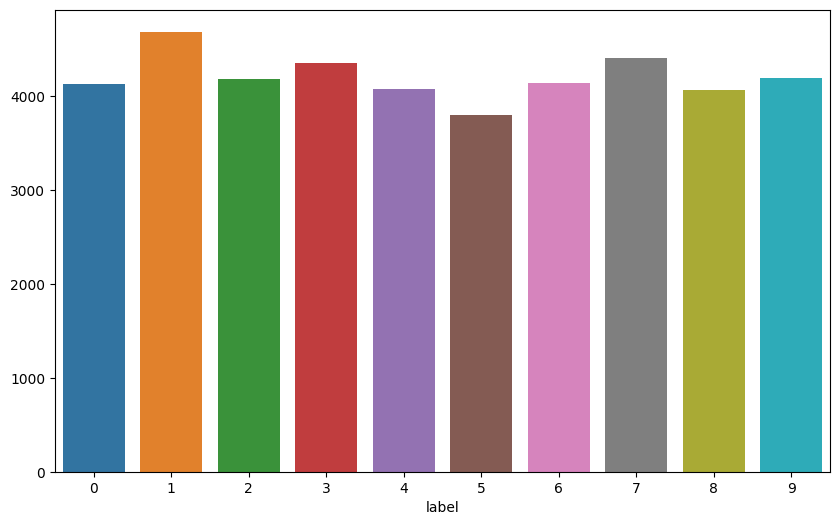

In [49]:
# Get the label counts from the DataFrame
label_counts = train_df['label'].value_counts()
label = set(train_df["label"])

# Plot with seaborn
plt.figure(figsize=(10,6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="tab10",legend=False)

In [88]:
def image_show(df, row_number, visualize=False, test_df=False):
    '''
        Parameters:
            df --> Pandas dataframe type
            row_number --> row index (For example: 0, 1, 2, 3, etc.)
            visualize --> If True then displays the raw data into 28 by 28 pixels image.
                          If False then returns '28 by 28 pixels reshaped image data' and 'corresponding label'
    '''
    row = df.iloc[row_number]
    if test_df:
      pixels = row.values[0:]
      label = None
    else:
      pixels = row.values[1:]
      label = row['label']



    # Reshape to 28x28 image
    image_2d = pixels.reshape(28, 28)

    if visualize:
        plt.imshow(image_2d, cmap='gray')
        plt.title(f"Label: {label}" if label is not None else "Test Image")
        plt.axis('off')
        plt.show()
    else:
        return image_2d, label

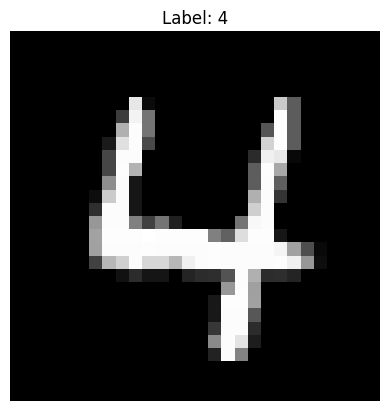

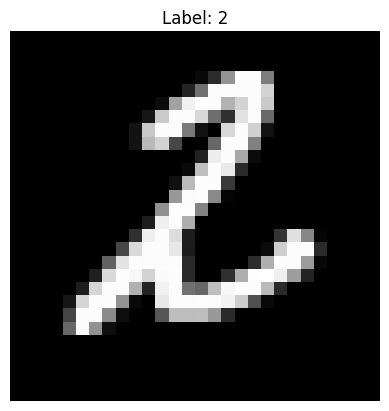

In [51]:
image_show(train_df, 42, visualize=True)
image_show(train_df, 4242, visualize=True)

In [158]:
def dataframe_formatter(df, isTest=False):
    """
    Formats a DataFrame containing image data for use in a machine learning model.

    :param df: The DataFrame containing image data.
    :param isTest: A boolean indicating whether the DataFrame is for testing data.
    :return: A tuple containing X (image data) and y (labels).
    """


    if isTest:
        return df.values[:, :]
    else:
        X = df.values[:, 1:]
        y = df.values[:,0]
        return (X,y)



In [105]:
X_train, y_train = dataframe_formatter(train_df, isTest=False)

In [106]:
# Split the data into a train and validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [172]:
# Create a CNN with PYTORCH !!!!!!!!!!!!!!!!!!!!!!!!!!
# Your inputs should have the same size as your images (same as in the reshape function above)
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=3*3*32, out_features=200)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(in_features=200, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        return F.softmax(x,dim=1)

# model = models.Sequential(  # Create the model with layers sequentially
#     [
#         ...,  # 2D convolutional layer with 20 filters, each 3x3, using ReLU activation, input shape is 28x28x1 (image dimensions)
#         ...,  # Max-pooling layer with a 2x2 window to reduce image size
#         ...,  # 2D convolutional layer with 32 filters, each 3x3, using ReLU activation
#         ...,  # Max-pooling layer with a 2x2 window
#         ...,  # 2D convolutional layer with 32 filters, each 2x2, using ReLU activation
#         ...,  # Max-pooling layer with a 2x2 window
#         ...,  # Flatten layer to convert the 2D output to 1D
#         ...,  # Fully connected layer with 200 neurons and ReLU activation
#         ...,  # Dropout layer with a dropout rate of 0.2 for regularization to prevent overfitting
#         ...  # Fully connected layer with 10 output units (classes) and sigmoid activation
#     ]
# )


In [173]:
model = ConvNet().to(device)
X_train = X_train.reshape(-1, 1, 28, 28)
X_val = X_val.reshape(-1, 1, 28, 28)
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
    batch_size=32, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)),
    batch_size=32, shuffle=False
)
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = np.inf
worse_count = 0

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for data, targets in tqdm(train_loader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(scores, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(scores, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    # Early stopping condition
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        worse_count = 0
    else:
        worse_count += 1
    if worse_count > 3:
        print("Validation loss worsened 3x — stopping training early!")
        break



Epoch [1/20]


100%|██████████| 1050/1050 [00:04<00:00, 252.76it/s]


Training Loss: 1.6725 | Training Accuracy: 79.23%
Validation Loss: 1.5891 | Validation Accuracy: 87.30%

Epoch [2/20]


100%|██████████| 1050/1050 [00:03<00:00, 280.97it/s]


Training Loss: 1.5897 | Training Accuracy: 87.14%
Validation Loss: 1.5861 | Validation Accuracy: 87.45%

Epoch [3/20]


100%|██████████| 1050/1050 [00:03<00:00, 267.82it/s]


Training Loss: 1.5560 | Training Accuracy: 90.58%
Validation Loss: 1.4906 | Validation Accuracy: 97.14%

Epoch [4/20]


100%|██████████| 1050/1050 [00:04<00:00, 243.47it/s]


Training Loss: 1.4917 | Training Accuracy: 97.04%
Validation Loss: 1.4850 | Validation Accuracy: 97.68%

Epoch [5/20]


100%|██████████| 1050/1050 [00:03<00:00, 295.37it/s]


Training Loss: 1.4872 | Training Accuracy: 97.42%
Validation Loss: 1.4833 | Validation Accuracy: 97.80%

Epoch [6/20]


100%|██████████| 1050/1050 [00:03<00:00, 280.50it/s]


Training Loss: 1.4821 | Training Accuracy: 97.90%
Validation Loss: 1.4787 | Validation Accuracy: 98.25%

Epoch [7/20]


100%|██████████| 1050/1050 [00:04<00:00, 242.02it/s]


Training Loss: 1.4813 | Training Accuracy: 97.99%
Validation Loss: 1.4795 | Validation Accuracy: 98.10%

Epoch [8/20]


100%|██████████| 1050/1050 [00:03<00:00, 275.16it/s]


Training Loss: 1.4787 | Training Accuracy: 98.28%
Validation Loss: 1.4798 | Validation Accuracy: 98.11%

Epoch [9/20]


100%|██████████| 1050/1050 [00:03<00:00, 265.01it/s]


Training Loss: 1.4788 | Training Accuracy: 98.25%
Validation Loss: 1.4800 | Validation Accuracy: 98.04%

Epoch [10/20]


100%|██████████| 1050/1050 [00:04<00:00, 257.95it/s]


Training Loss: 1.4774 | Training Accuracy: 98.38%
Validation Loss: 1.4807 | Validation Accuracy: 98.05%
Validation loss worsened 3x — stopping training early!


In [174]:
# Read the data from the CSV file using Pandas
test_df = pd.read_csv("test.csv")

In [175]:
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
X_test = dataframe_formatter(test_df, isTest=True)
print(X_test.shape)
X_test = X_test.reshape(-1, 1, 28, 28)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

(28000, 784)


In [177]:
predictions = model(X_test)

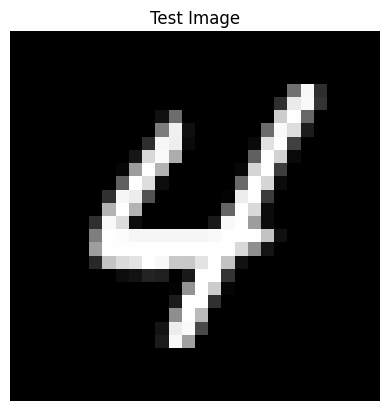

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward0>)


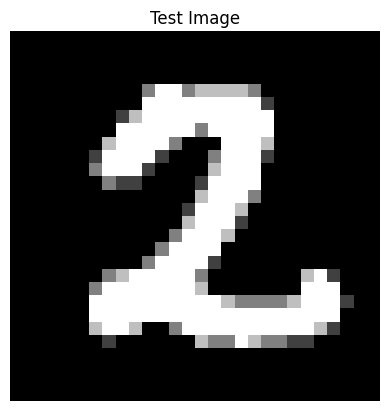

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [178]:
image_show(test_df, 42, visualize=True, test_df=True)
print(predictions[42])
image_show(test_df, 4242, visualize=True, test_df=True)
print(predictions[4242])